# Comments
Thanks to tito for this great script https://www.kaggle.com/its7171/lgbm-with-loop-feature-engineering

* Creating predictive feature is very important, here I just used 14 features and 15M data points to train the model.
* The dataset is big to preprocess using python with a for loop, their are other tools and frameworks like (SQL, Spark, Apache Beam, Dask) where you could make feature engineering much faster but if we are smart and make predictive feature it's ok to just use for loops.
* Foward feature engineering seems a good technique to try in this problem (create 1 new feature that you think it could be predective based on the problem, run the pipeline and check if val score increase, if it increase that feature is predictive and you should add it. Care when you just get some minor improvement, sometime is better to discard that feature because your experimentation process is going to get slower).

In [1]:
import pandas as pd
import numpy as np
import gc
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from tqdm.notebook import tqdm
import lightgbm as lgb
import riiideducation
import matplotlib.pyplot as plt
import seaborn as sns

import random
import os

User feature calculation started...


User feature calculation completed...


Traning with 15000000 rows and 14 features
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.765191	valid_1's auc: 0.770159
[100]	training's auc: 0.768747	valid_1's auc: 0.773647
[150]	training's auc: 0.770044	valid_1's auc: 0.774852
[200]	training's auc: 0.77074	valid_1's auc: 0.775521
[250]	training's auc: 0.771305	valid_1's auc: 0.776018
[300]	training's auc: 0.771862	valid_1's auc: 0.776522
[350]	training's auc: 0.772251	valid_1's auc: 0.776846
[400]	training's auc: 0.772538	valid_1's auc: 0.777067
[450]	training's auc: 0.772872	valid_1's auc: 0.777338
[500]	training's auc: 0.773123	valid_1's auc: 0.777521
[550]	training's auc: 0.773348	valid_1's auc: 0.777659
[600]	training's auc: 0.773616	valid_1's auc: 0.777857
[650]	training's auc: 0.773839	valid_1's auc: 0.777995
[700]	training's auc: 0.774036	valid_1's auc: 0.778116
[750]	training's auc: 0.77422	valid_1's auc: 0.778

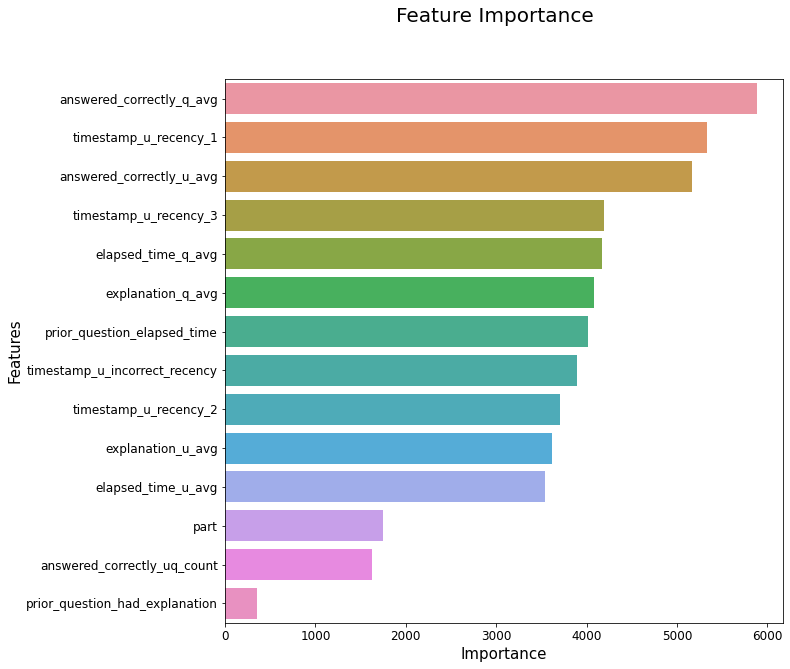

Job Done


In [2]:
# Random seed
SEED = 123

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(SEED)


# Funcion for user stats with loops
def add_features(df, answered_correctly_u_count, answered_correctly_u_sum, elapsed_time_u_sum, explanation_u_sum, timestamp_u, timestamp_u_incorrect, answered_correctly_q_count, answered_correctly_q_sum, elapsed_time_q_sum, explanation_q_sum, answered_correctly_uq, update = True):
    # -----------------------------------------------------------------------
    # Client features
    answered_correctly_u_avg = np.zeros(len(df), dtype = np.float32)
    elapsed_time_u_avg = np.zeros(len(df), dtype = np.float32)
    explanation_u_avg = np.zeros(len(df), dtype = np.float32)
    timestamp_u_recency_1 = np.zeros(len(df), dtype = np.float32)
    timestamp_u_recency_2 = np.zeros(len(df), dtype = np.float32)
    timestamp_u_recency_3 = np.zeros(len(df), dtype = np.float32)
    timestamp_u_incorrect_recency = np.zeros(len(df), dtype = np.float32)
    # -----------------------------------------------------------------------
    # Question features
    answered_correctly_q_avg = np.zeros(len(df), dtype = np.float32)
    elapsed_time_q_avg = np.zeros(len(df), dtype = np.float32)
    explanation_q_avg = np.zeros(len(df), dtype = np.float32)
    # -----------------------------------------------------------------------
    # User Question
    answered_correctly_uq_count = np.zeros(len(df), dtype = np.int32)
    # -----------------------------------------------------------------------
    
    for num, row in enumerate(df[['user_id', 'answered_correctly', 'content_id', 'prior_question_elapsed_time', 'prior_question_had_explanation', 'timestamp']].values):
        
        # Client features assignation
        # ------------------------------------------------------------------
        if answered_correctly_u_count[row[0]] != 0:
            answered_correctly_u_avg[num] = answered_correctly_u_sum[row[0]] / answered_correctly_u_count[row[0]]
            elapsed_time_u_avg[num] = elapsed_time_u_sum[row[0]] / answered_correctly_u_count[row[0]]
            explanation_u_avg[num] = explanation_u_sum[row[0]] / answered_correctly_u_count[row[0]]
        else:
            answered_correctly_u_avg[num] = np.nan
            elapsed_time_u_avg[num] = np.nan
            explanation_u_avg[num] = np.nan
            
        if len(timestamp_u[row[0]]) == 0:
            timestamp_u_recency_1[num] = np.nan
            timestamp_u_recency_2[num] = np.nan
            timestamp_u_recency_3[num] = np.nan
        elif len(timestamp_u[row[0]]) == 1:
            timestamp_u_recency_1[num] = row[5] - timestamp_u[row[0]][0]
            timestamp_u_recency_2[num] = np.nan
            timestamp_u_recency_3[num] = np.nan
        elif len(timestamp_u[row[0]]) == 2:
            timestamp_u_recency_1[num] = row[5] - timestamp_u[row[0]][1]
            timestamp_u_recency_2[num] = row[5] - timestamp_u[row[0]][0]
            timestamp_u_recency_3[num] = np.nan
        elif len(timestamp_u[row[0]]) == 3:
            timestamp_u_recency_1[num] = row[5] - timestamp_u[row[0]][2]
            timestamp_u_recency_2[num] = row[5] - timestamp_u[row[0]][1]
            timestamp_u_recency_3[num] = row[5] - timestamp_u[row[0]][0]
        
        if len(timestamp_u_incorrect[row[0]]) == 0:
            timestamp_u_incorrect_recency[num] = np.nan
        else:
            timestamp_u_incorrect_recency[num] = row[5] - timestamp_u_incorrect[row[0]][0]
            
        # ------------------------------------------------------------------
        # Question features assignation
        if answered_correctly_q_count[row[2]] != 0:
            answered_correctly_q_avg[num] = answered_correctly_q_sum[row[2]] / answered_correctly_q_count[row[2]]
            elapsed_time_q_avg[num] = elapsed_time_q_sum[row[2]] / answered_correctly_q_count[row[2]]
            explanation_q_avg[num] = explanation_q_sum[row[2]] / answered_correctly_q_count[row[2]]
        else:
            answered_correctly_q_avg[num] = np.nan
            elapsed_time_q_avg[num] = np.nan
            explanation_q_avg[num] = np.nan
        # ------------------------------------------------------------------
        # Client Question assignation
        answered_correctly_uq_count[num] = answered_correctly_uq[row[0]][row[2]]
        # ------------------------------------------------------------------
        # ------------------------------------------------------------------
        # Client features updates
        answered_correctly_u_count[row[0]] += 1
        elapsed_time_u_sum[row[0]] += row[3]
        explanation_u_sum[row[0]] += int(row[4])
        if len(timestamp_u[row[0]]) == 3:
            timestamp_u[row[0]].pop(0)
            timestamp_u[row[0]].append(row[5])
        else:
            timestamp_u[row[0]].append(row[5])
        # ------------------------------------------------------------------
        # Question features updates
        answered_correctly_q_count[row[2]] += 1
        elapsed_time_q_sum[row[2]] += row[3]
        explanation_q_sum[row[2]] += int(row[4])
        # ------------------------------------------------------------------
        # Client Question updates
        answered_correctly_uq[row[0]][row[2]] += 1
        # ------------------------------------------------------------------
        # Flag for training and inference
        if update:
            # ------------------------------------------------------------------
            # Client features updates
            answered_correctly_u_sum[row[0]] += row[1]
            if row[1] == 0:
                if len(timestamp_u_incorrect[row[0]]) == 1:
                    timestamp_u_incorrect[row[0]].pop(0)
                    timestamp_u_incorrect[row[0]].append(row[5])
                else:
                    timestamp_u_incorrect[row[0]].append(row[5])
            
            # ------------------------------------------------------------------
            # Question features updates
            answered_correctly_q_sum[row[2]] += row[1]
            # ------------------------------------------------------------------
             
            
    user_df = pd.DataFrame({'answered_correctly_u_avg': answered_correctly_u_avg, 'elapsed_time_u_avg': elapsed_time_u_avg, 'explanation_u_avg': explanation_u_avg, 
                            'answered_correctly_q_avg': answered_correctly_q_avg, 'elapsed_time_q_avg': elapsed_time_q_avg, 'explanation_q_avg': explanation_q_avg, 
                            'answered_correctly_uq_count': answered_correctly_uq_count, 'timestamp_u_recency_1': timestamp_u_recency_1, 'timestamp_u_recency_2': timestamp_u_recency_2,
                            'timestamp_u_recency_3': timestamp_u_recency_3, 'timestamp_u_incorrect_recency': timestamp_u_incorrect_recency})
    
    df = pd.concat([df, user_df], axis = 1)
    return df
        
def update_features(df, answered_correctly_u_sum, answered_correctly_q_sum, timestamp_u_incorrect):
    for row in df[['user_id', 'answered_correctly', 'content_id', 'content_type_id', 'timestamp']].values:
        if row[3] == 0:
            # ------------------------------------------------------------------
            # Client features updates
            answered_correctly_u_sum[row[0]] += row[1]
            if row[1] == 0:
                if len(timestamp_u_incorrect[row[0]]) == 1:
                    timestamp_u_incorrect[row[0]].pop(0)
                    timestamp_u_incorrect[row[0]].append(row[4])
                else:
                    timestamp_u_incorrect[row[0]].append(row[4])
            # ------------------------------------------------------------------
            # Question features updates
            answered_correctly_q_sum[row[2]] += row[1]
            # ------------------------------------------------------------------
            
    return

def read_and_preprocess(feature_engineering = False):
    
    train_pickle = '../input/riiid-cross-validation-files/cv1_train.pickle'
    valid_pickle = '../input/riiid-cross-validation-files/cv1_valid.pickle'
    question_file = '../input/riiid-test-answer-prediction/questions.csv'
    
    # Read data
    feld_needed = ['timestamp', 'user_id', 'answered_correctly', 'content_id', 'content_type_id', 'prior_question_elapsed_time', 'prior_question_had_explanation']
    train = pd.read_pickle(train_pickle)[feld_needed]
    valid = pd.read_pickle(valid_pickle)[feld_needed]
    # Delete some trianing data to don't have ram problems
    if feature_engineering:
        train = train.iloc[-40000000:]
    
    # Filter by content_type_id to discard lectures
    train = train.loc[train.content_type_id == False].reset_index(drop = True)
    valid = valid.loc[valid.content_type_id == False].reset_index(drop = True)
    
    # Changing dtype to avoid lightgbm error
    train['prior_question_had_explanation'] = train.prior_question_had_explanation.fillna(False).astype('int8')
    valid['prior_question_had_explanation'] = valid.prior_question_had_explanation.fillna(False).astype('int8')
    
    # Fill prior question elapsed time with the mean
    prior_question_elapsed_time_mean = train['prior_question_elapsed_time'].dropna().mean()
    train['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace = True)
    valid['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace = True)
    
    # Merge with question dataframe
    questions_df = pd.read_csv(question_file)
    questions_df['part'] = questions_df['part'].astype(np.int32)
    questions_df['bundle_id'] = questions_df['bundle_id'].astype(np.int32)
    
    train = pd.merge(train, questions_df[['question_id', 'part']], left_on = 'content_id', right_on = 'question_id', how = 'left')
    valid = pd.merge(valid, questions_df[['question_id', 'part']], left_on = 'content_id', right_on = 'question_id', how = 'left')
    
    # Client dictionaries
    answered_correctly_u_count = defaultdict(int)
    answered_correctly_u_sum = defaultdict(int)
    elapsed_time_u_sum = defaultdict(int)
    explanation_u_sum = defaultdict(int)
    timestamp_u = defaultdict(list)
    timestamp_u_incorrect = defaultdict(list)
    
    # Question dictionaries
    answered_correctly_q_count = defaultdict(int)
    answered_correctly_q_sum = defaultdict(int)
    elapsed_time_q_sum = defaultdict(int)
    explanation_q_sum = defaultdict(int)
    
    # Client Question dictionary
    answered_correctly_uq = defaultdict(lambda: defaultdict(int))
    
    print('User feature calculation started...')
    print('\n')
    train = add_features(train, answered_correctly_u_count, answered_correctly_u_sum, elapsed_time_u_sum, explanation_u_sum, timestamp_u, timestamp_u_incorrect, answered_correctly_q_count, answered_correctly_q_sum, elapsed_time_q_sum, explanation_q_sum, answered_correctly_uq)
    valid = add_features(valid, answered_correctly_u_count, answered_correctly_u_sum, elapsed_time_u_sum, explanation_u_sum, timestamp_u, timestamp_u_incorrect, answered_correctly_q_count, answered_correctly_q_sum, elapsed_time_q_sum, explanation_q_sum, answered_correctly_uq)
    gc.collect()
    print('User feature calculation completed...')
    print('\n')
    
    features_dicts = {
        'answered_correctly_u_count': answered_correctly_u_count,
        'answered_correctly_u_sum': answered_correctly_u_sum,
        'elapsed_time_u_sum': elapsed_time_u_sum,
        'explanation_u_sum': explanation_u_sum,
        'answered_correctly_q_count': answered_correctly_q_count,
        'answered_correctly_q_sum': answered_correctly_q_sum,
        'elapsed_time_q_sum': elapsed_time_q_sum,
        'explanation_q_sum': explanation_q_sum,
        'answered_correctly_uq': answered_correctly_uq,
        'timestamp_u': timestamp_u,
        'timestamp_u_incorrect': timestamp_u_incorrect
    }
    
    return train, valid, questions_df, prior_question_elapsed_time_mean, features_dicts

# Function for training and evaluation
def train_and_evaluate(train, valid, feature_engineering = False):
    
    TARGET = 'answered_correctly'
    # Features to train and predict
    FEATURES = ['prior_question_elapsed_time', 'prior_question_had_explanation', 'part', 'answered_correctly_u_avg', 'elapsed_time_u_avg', 'explanation_u_avg',
                'answered_correctly_q_avg', 'elapsed_time_q_avg', 'explanation_q_avg', 'answered_correctly_uq_count', 'timestamp_u_recency_1', 'timestamp_u_recency_2', 'timestamp_u_recency_3', 
                'timestamp_u_incorrect_recency']
    
    # Delete some training data to experiment faster
    if feature_engineering:
        train = train.sample(15000000, random_state = SEED)
    gc.collect()
    print(f'Traning with {train.shape[0]} rows and {len(FEATURES)} features')    
    drop_cols = list(set(train.columns) - set(FEATURES))
    y_train = train[TARGET]
    y_val = valid[TARGET]
    # Drop unnecessary columns
    train.drop(drop_cols, axis = 1, inplace = True)
    valid.drop(drop_cols, axis = 1, inplace = True)
    gc.collect()
    
    lgb_train = lgb.Dataset(train[FEATURES], y_train)
    lgb_valid = lgb.Dataset(valid[FEATURES], y_val)
    del train, y_train
    gc.collect()
    
#     params = {'objective': 'binary', 
#               'seed': SEED,
#               'metric': 'auc',
#               'num_leaves': 200,
#               'feature_fraction': 0.75,
#               'bagging_freq': 10,
#               'bagging_fraction': 0.80
#              }
    params = {'objective': 'binary',
          'metric': 'auc',
          'seed': 2020,
          'learning_rate': 0.1, #default
          "boosting_type": "gbdt" #default
         }
    model = lgb.train(
        params = params,
        train_set = lgb_train,
        num_boost_round = 10000,
        valid_sets = [lgb_train, lgb_valid],
        early_stopping_rounds = 10,
        verbose_eval = 50
    )
    
    print('Our Roc Auc score for the validation data is:', roc_auc_score(y_val, model.predict(valid[FEATURES])))
    
    feature_importance = model.feature_importance()
    feature_importance = pd.DataFrame({'Features': FEATURES, 'Importance': feature_importance}).sort_values('Importance', ascending = False)
    
    fig = plt.figure(figsize = (10, 10))
    fig.suptitle('Feature Importance', fontsize = 20)
    plt.tick_params(axis = 'x', labelsize = 12)
    plt.tick_params(axis = 'y', labelsize = 12)
    plt.xlabel('Importance', fontsize = 15)
    plt.ylabel('Features', fontsize = 15)
    sns.barplot(x = feature_importance['Importance'], y = feature_importance['Features'], orient = 'h')
    plt.show()
    
    return TARGET, FEATURES, model

# Using time series api that simulates production predictions
def inference(TARGET, FEATURES, model, questions_df, prior_question_elapsed_time_mean, features_dicts):
    
    # Get feature dict
    answered_correctly_u_count = features_dicts['answered_correctly_u_count']
    answered_correctly_u_sum = features_dicts['answered_correctly_u_sum']
    elapsed_time_u_sum = features_dicts['elapsed_time_u_sum']
    explanation_u_sum = features_dicts['explanation_u_sum']
    answered_correctly_q_count = features_dicts['answered_correctly_q_count']
    answered_correctly_q_sum = features_dicts['answered_correctly_q_sum']
    elapsed_time_q_sum = features_dicts['elapsed_time_q_sum']
    explanation_q_sum = features_dicts['explanation_q_sum']
    answered_correctly_uq = features_dicts['answered_correctly_uq']
    timestamp_u = features_dicts['timestamp_u']
    timestamp_u_incorrect = features_dicts['timestamp_u_incorrect']
    
    # Get api iterator and predictor
    env = riiideducation.make_env()
    iter_test = env.iter_test()
    set_predict = env.predict
    
    previous_test_df = None
    for (test_df, sample_prediction_df) in iter_test:
        if previous_test_df is not None:
            previous_test_df[TARGET] = eval(test_df["prior_group_answers_correct"].iloc[0])
            update_features(previous_test_df, answered_correctly_u_sum, answered_correctly_q_sum, timestamp_u_incorrect)
        previous_test_df = test_df.copy()
        test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop = True)
        test_df['prior_question_had_explanation'] = test_df.prior_question_had_explanation.fillna(False).astype('int8')
        test_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace = True)
        test_df = pd.merge(test_df, questions_df[['question_id', 'part']], left_on = 'content_id', right_on = 'question_id', how = 'left')
        test_df[TARGET] = 0
        test_df = add_features(test_df, answered_correctly_u_count, answered_correctly_u_sum, elapsed_time_u_sum, explanation_u_sum, timestamp_u, timestamp_u_incorrect, answered_correctly_q_count, answered_correctly_q_sum, elapsed_time_q_sum, explanation_q_sum, answered_correctly_uq, update = False)
        test_df[TARGET] =  model.predict(test_df[FEATURES])
        set_predict(test_df[['row_id', TARGET]])
        
    print('Job Done')
    
train, valid, questions_df, prior_question_elapsed_time_mean, features_dicts = read_and_preprocess(feature_engineering = True)
TARGET, FEATURES, model = train_and_evaluate(train, valid, feature_engineering = True)
inference(TARGET, FEATURES, model, questions_df, prior_question_elapsed_time_mean, features_dicts)